## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [31]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

### Data Load

In [32]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_19.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_19.csv')

DI_train = pd.read_csv('../data/DI_train_dataset_19.csv')
DI_test = pd.read_csv('../data/DI_test_dataset_19.csv')

In [33]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

### 인코딩 

In [34]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "배란_유도_유형",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [35]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [36]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [37]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

### IVF 데이터

In [38]:
# 타겟 변수 비율 계산
positive_samples = IVF_train[IVF_train['임신_성공_여부'] == 1].shape[0]
negative_samples = IVF_train[IVF_train['임신_성공_여부'] == 0].shape[0]
scale_pos_weight = negative_samples / positive_samples

In [39]:
scale_pos_weight

2.822548345180769


--- Model Performance ---
Model Accuracy: 0.6179040611065566
Model F1 Score: 0.5174373090229551
Model AUC: 0.7402667820644281


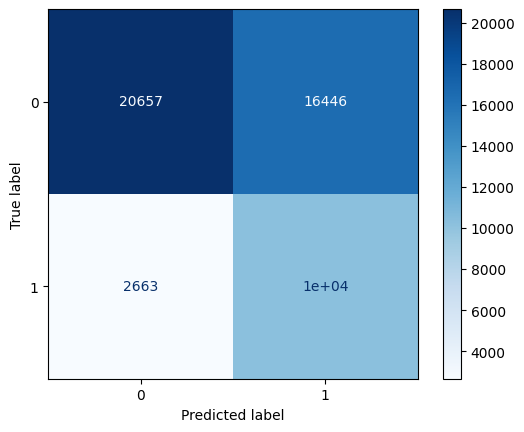

In [40]:
# 모델 초기화
IVF_model = lgb.LGBMClassifier(
    n_estimators=4471,
    num_leaves=13,
    max_depth=279,
    learning_rate=0.007075124517450591,
    min_child_samples=26,
    subsample=0.29772991936701476,
    colsample_bytree=0.8913054521763838,
    reg_alpha=0.0004860363321690653,
    reg_lambda=311.08056657247363,
    min_split_gain=0.18214905183450955,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1,
    scale_pos_weight=scale_pos_weight
)

# 모델 학습
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DI 데이터

In [41]:
# 타겟 변수 비율 계산
positive_samples = DI_y_train[DI_y_train == 1].shape[0]
negative_samples = DI_y_train[DI_y_train == 0].shape[0]
scale_pos_weight = negative_samples / positive_samples


--- Model Performance ---
Model Accuracy: 0.6383147853736089
Model F1 Score: 0.32791728212703103
Model AUC: 0.7136631716906945


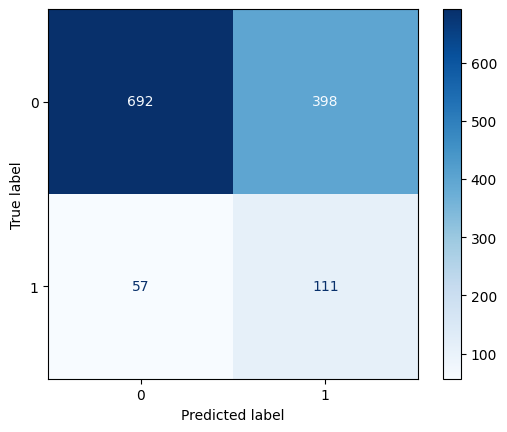

In [42]:
# 모델 초기화
DI_model = lgb.LGBMClassifier(
    n_estimators=1816,
    num_leaves=3926,
    max_depth=259,
    learning_rate=0.00238377640011148,
    min_child_samples=1,
    subsample=0.7610056627240331,
    colsample_bytree=0.6655579164853634,
    reg_alpha=0.00025227758337188327,
    reg_lambda=76.744107215122684,
    min_split_gain=0.007773520329665474,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1,
    scale_pos_weight=scale_pos_weight  # 클래스 불균형 처리
)

# 모델 학습
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.618404884042989
Model F1 Score: 0.5142516635217003
Model AUC: 0.7407486012120966


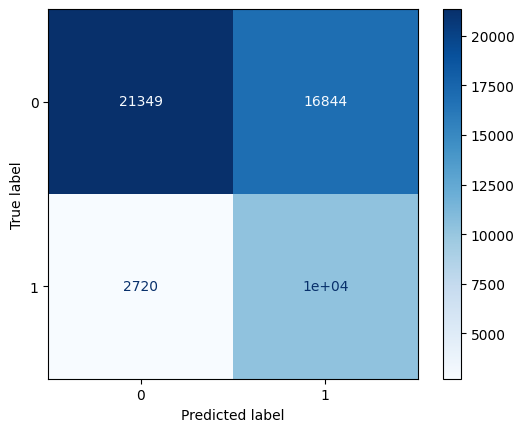

In [43]:
# 예측
IVF_y_pred = IVF_model.predict(IVF_X_test)
IVF_y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

DI_y_pred = DI_model.predict(DI_X_test)
DI_y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

데이콘 PUBLIC 0.7397350797

## 제출

In [44]:
# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [45]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('../submission/code19_submit.csv', index=False, encoding='utf-8')

.